In [61]:
from pylab import *
import sys
import caffe
from caffe import layers as L, params as P
import numpy as np
%matplotlib inline

In [3]:
caffe_root = '/opt/caffe'  # this file should be run from {caffe_root}/examples (otherwise change this line)

sys.path.insert(0, caffe_root + 'python')

In [4]:
# run scripts from caffe root
import os
os.chdir(caffe_root)
# Download data
!data/mnist/get_mnist.sh
# Prepare data
!examples/mnist/create_mnist.sh
# back to examples
os.chdir('examples')

Downloading...
Creating lmdb...
libdc1394 error: Failed to initialize libdc1394
I1118 03:28:32.325736   118 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I1118 03:28:32.325899   118 convert_mnist_data.cpp:88] A total of 60000 items.
I1118 03:28:32.325906   118 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I1118 03:28:33.280158   118 convert_mnist_data.cpp:108] Processed 60000 files.
libdc1394 error: Failed to initialize libdc1394
I1118 03:28:33.300992   119 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I1118 03:28:33.301234   119 convert_mnist_data.cpp:88] A total of 10000 items.
I1118 03:28:33.301245   119 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I1118 03:28:33.418190   119 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


In [5]:
def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
    
with open('mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))

In [8]:
### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

In [11]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(2.327704906463623, dtype=float32)}

In [116]:
!cat mnist/lenet_solver.prototxt

# The train/test net protocol buffer definition
net: "examples/mnist/lenet_train_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "examples/mnist/lenet"
# solver mode: CPU or GPU
solver_mode: CPU


train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


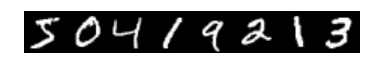

In [14]:
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


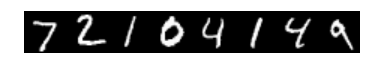

In [15]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

In [16]:
solver.step(1)

(-0.5, 24.5, 19.5, -0.5)

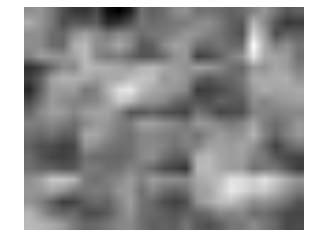

In [22]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); axis('off')

In [18]:
%%time
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 47.5 s, sys: 111 ms, total: 47.6 s
Wall time: 47.1 s


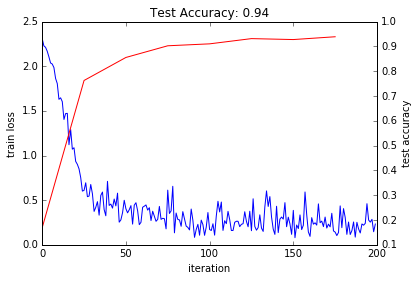

In [19]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

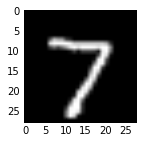

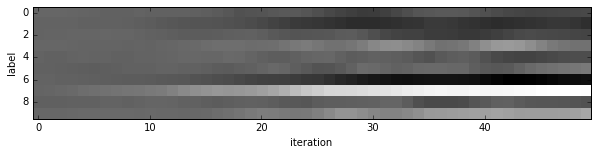

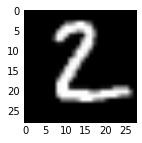

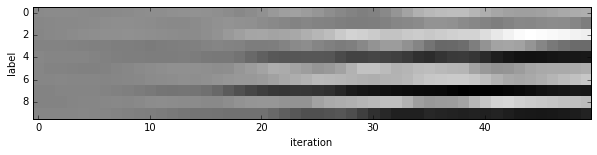

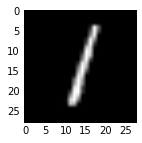

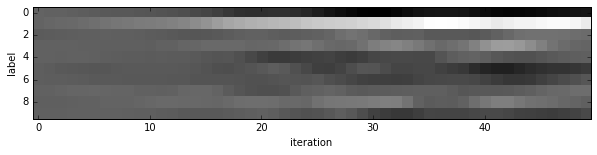

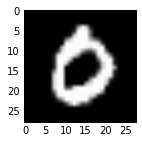

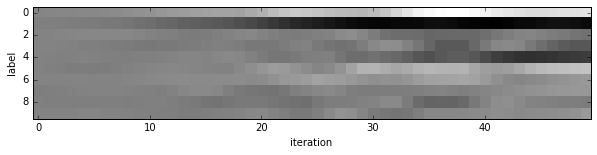

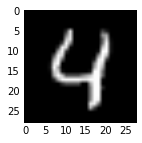

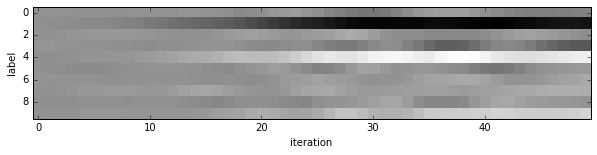

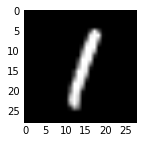

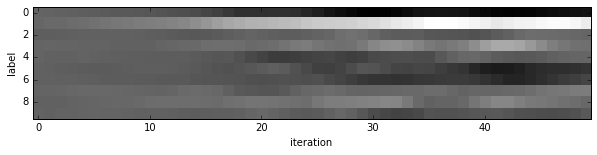

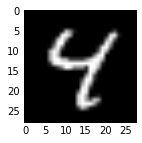

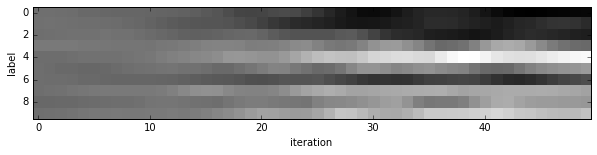

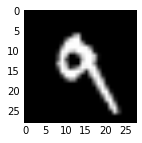

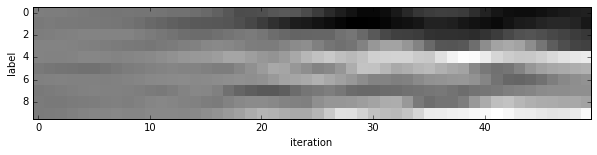

In [20]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

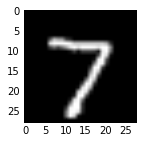

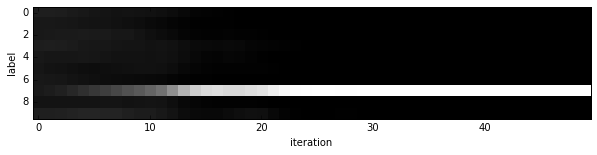

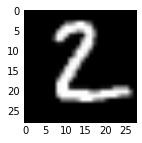

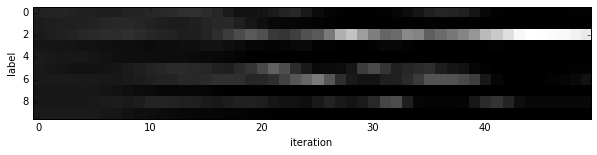

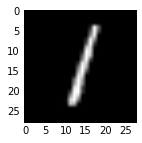

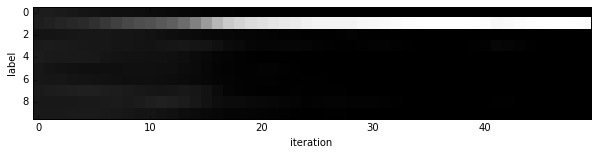

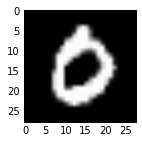

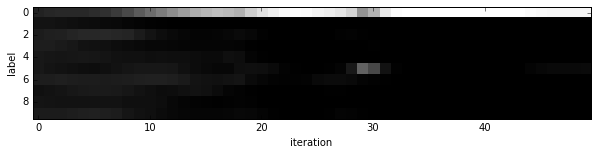

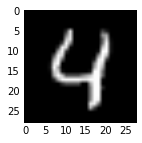

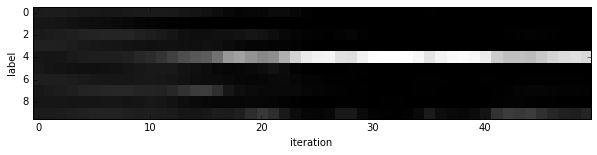

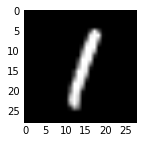

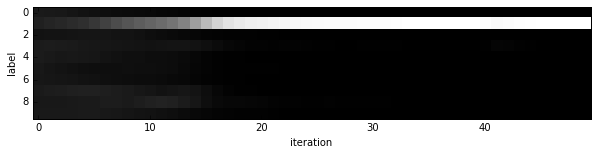

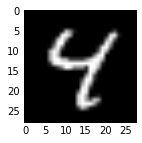

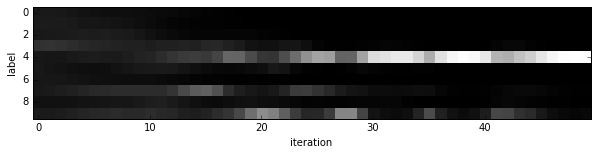

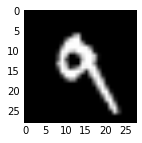

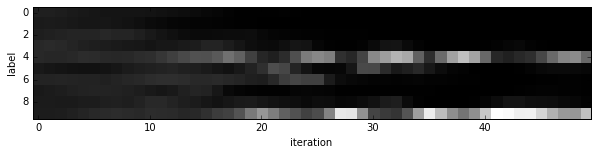

In [21]:
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(exp(output[:50, i].T) / exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

In [103]:
# Get the population of images to deal with, find a start and end image
target_digit = 9
digit_indexes = ((solver.test_nets[0].blobs['label'].data == target_digit) & 
                (solver.test_nets[0].blobs['score'].data.argmax(1) == target_digit))
digits = solver.test_nets[0].blobs['data'].data[digit_indexes] 
start_img, end_img = [k[0] for k in digits[np.random.choice(digits.shape[0], 2, replace=False), :]]

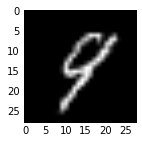

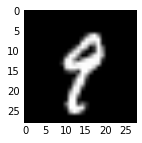

In [104]:
# Show start and end images
figure(figsize=(2, 2))
imshow(start_img, cmap='gray')
figure(figsize=(2, 2))
imshow(end_img, cmap='gray')

In [112]:
solver.test_nets[0].blobs['data'].data[...] = start_img
output = solver.test_nets[0].forward()


array([[ -5.45015860e+00,   7.52058983e+00,   5.20599604e-01,
          9.02720869e-01,  -4.99260336e-01,  -4.24682915e-01,
         -2.23150134e+00,  -1.89092970e+00,   1.14286959e+00,
          1.49470672e-01],
       [  1.08892889e+01,  -4.25002193e+00,   1.36881375e+00,
         -2.54582644e+00,  -5.21237850e+00,   2.55763650e+00,
          1.11412096e+00,  -4.94586039e+00,  -2.29208899e+00,
         -1.80808365e+00],
       [ -4.23517942e+00,   1.00286591e+00,   4.40647364e+00,
          2.17375207e+00,  -2.19745684e+00,  -4.73859310e+00,
         -8.69268513e+00,   9.34078217e+00,  -3.93646026e+00,
          4.81836939e+00],
       [ -6.13875055e+00,  -6.05908513e-01,   6.68064260e+00,
          4.41514349e+00,  -1.88512838e+00,  -2.82960439e+00,
         -7.76101828e+00,   9.21649742e+00,  -3.11664939e+00,
          2.26595330e+00],
       [  8.54509449e+00,  -3.14266729e+00,   1.65282619e+00,
         -1.41791463e+00,  -4.11621666e+00,   2.74485731e+00,
          2.42958590e-02

{'loss': array(0.2202812135219574, dtype=float32)}